# Overfitting & Regularization

- IMBD 를 이용하여 overfitting 과 regularization test  
- Colab 에서는 메모리 부족 발생하므로 Local 에서 실행

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUM_WORDS = 10000

(train_data, train_label), (test_data, test_label) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [3]:
print(train_data[0])
print()
print(train_label[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

1


### Multi-hot-encoding

Multi-hot encoding은 텍스트 데이터를 벡터 형식으로 변환하는 방법 중 하나입니다. 주로 단어의 집합 또는 어휘를 다룰 때 사용됩니다.

Multi-hot encoding의 결과를 설명하겠습니다:

1. **어휘 크기**: 우선 어휘의 전체 크기, 즉 데이터에 있는 모든 고유한 단어의 수를 기반으로 고정 길이의 벡터를 설정합니다. 예를 들어, 어휘에 10,000개의 고유한 단어가 있다면 각 문서나 시퀀스를 나타내는 벡터의 길이도 10,000이 됩니다.

2. **벡터화**: 각 문서나 시퀀스는 이 10,000개의 요소를 가진 벡터로 표현됩니다. 문서에 특정 단어가 포함되어 있다면, 해당 단어의 인덱스에 해당하는 벡터의 위치에 1을 설정합니다. 그렇지 않으면 0을 설정합니다.

예를 들어:
- 어휘: ["apple", "banana", "cherry", "date", "fig"]
- 문서: "apple cherry"

이 문서를 multi-hot encoding으로 벡터화하면 다음과 같습니다:
- 벡터: [1, 0, 1, 0, 0]

Multi-hot encoding의 결과는 각 문서나 시퀀스를 고정 길이의 벡터로 변환하는 것입니다. 이 벡터는 주어진 어휘에 있는 각 단어의 존재 유무를 나타냅니다. 이 방식은 원-핫 인코딩과 유사하지만, 하나 이상의 1 값을 가질 수 있기 때문에 "multi-hot"이라고 합니다.

다음의 요령으로 train_data, test_data 를 **multi-hot-encoding** 합니다.

In [4]:
test = np.zeros((2,10))
test[0, [1,2,3]] = 1
test[1, [5,6,7]] = 1
print(test)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]]


In [5]:
def multi_hot_sequences(sequences, dimensions):
    results = np.zeros((len(sequences), dimensions))
    for i, word_index in enumerate(sequences):
        results[i, word_index] = 1.0
        return results

In [6]:
X_train = multi_hot_sequences(train_data, NUM_WORDS)
X_test  = multi_hot_sequences(test_data, NUM_WORDS)

X_train.shape, X_test.shape

((25000, 10000), (25000, 10000))

In [7]:
X_train[0], X_test[1]

(array([0., 1., 1., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

## 3 가지 크기의 model 을 만들어 underfitting, overfitting 을 비교

- metrics = ['accuracy', 'binary_crossentropy'] 로 주고 history.histroy['val_binary_crossentropy'] 를 서로 비교한다.

In [8]:
def make_model(neurons, regularizer=None, dropout=0.0):
    model = keras.Sequential()
    model.add(Dense(neurons,
                    kernel_regularizer=regularizer, activation="relu", input_shape=(NUM_WORDS,)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_regularizer=regularizer, activation="relu"))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_crossentropy'])
    return model

In [9]:
regularizer = None
dropout = 0.0

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

In [10]:
%%time

history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

Epoch 1/20
49/49 [==============================] - 2s 31ms/step - loss: 0.6932 - accuracy: 0.4983 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 2/20
49/49 [==============================] - 1s 19ms/step - loss: 0.6931 - accuracy: 0.5000 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 3/20
49/49 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5000 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 4/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.4988 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 5/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5000 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_bin

Epoch 1/20
49/49 [==============================] - 5s 92ms/step - loss: 0.6932 - accuracy: 0.4954 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 2/20
49/49 [==============================] - 4s 82ms/step - loss: 0.6932 - accuracy: 0.5012 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 3/20
49/49 [==============================] - 4s 78ms/step - loss: 0.6931 - accuracy: 0.4985 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 4/20
49/49 [==============================] - 4s 78ms/step - loss: 0.6931 - accuracy: 0.4964 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 5/20
49/49 [==============================] - 4s 80ms/step - loss: 0.6931 - accuracy: 0.4980 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_bin

### 한 figure 에 model_1,2,3 를 모두 그리고, 각각의 train / validation loss 를 같은 색으로 그린다.

- history.epoch : epoch 수  


- history.history['binary_crossentropy'] : train loss  


- history.history['val_binary_crossentropy'] : validation loss  


- plt.plot return value 의 get_color() 를 이용해 같은 색으로 그릴 수 있다

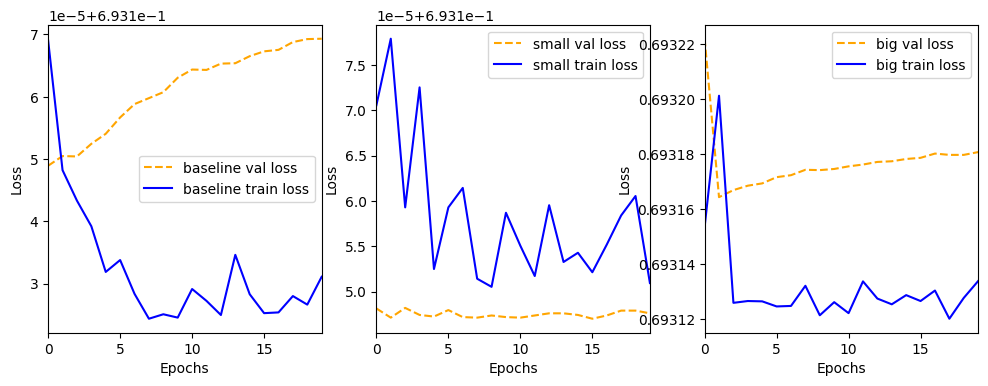

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, history) in enumerate([('baseline', history1), ('small', history2), ('big', history3)]):
    ax[i].plot(history.history['val_loss'], '--', label=name + ' val loss', color='orange')
    ax[i].plot(history.history['loss'], label=name + ' train loss', color='blue')
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].set_xlim([0, max(history.epoch)])

## l2 regularization 을 적용하여 같은 Test

L2 regularization은 머신 러닝 및 딥 러닝에서 모델의 가중치에 제약을 부과하여 오버피팅을 방지하는 기술입니다. 이는 모델의 복잡성을 제한하며, 일반화 능력을 향상시키는 데 도움이 됩니다.

L2 regularization을 사용할 때, 손실 함수에 가중치의 제곱에 비례하는 항이 추가됩니다. 이는 모델이 학습하는 동안 가중치가 큰 값을 가지게 되면 높은 페널티가 부과되도록 하는 역할을 합니다.

아래는 L2 regularization에 대한 자세한 설명입니다:

1. **식**:
$$J_{\text{regularized}} = J + \lambda \sum_{i} w_{i}^{2}$$
여기서 \( J \)는 원래의 손실 함수, \( w \)는 모델의 가중치, 그리고 $\lambda$는 regularization strength를 의미합니다.  


2. **정규화 강도**:
`keras.regularizers.l2(0.001)`에서 `0.001`은 $\lambda$ 값, 즉 regularization strength를 나타냅니다. 이 값이 크면 가중치에 대한 제약이 강화되며, 값이 작으면 제약이 약화됩니다.


3. **장점**:   
   - 가중치의 큰 값을 갖는 것에 페널티를 부과하여 오버피팅을 방지합니다.
   - 모델의 일반화 능력을 향상시킵니다.
   - 피처 간의 공선성 문제를 완화시킵니다.  
   

4. **사용 방법**:
Keras에서 L2 regularization을 사용하려면, 해당 regularizer 객체를 레이어의 `kernel_regularizer` 인자로 전달하면 됩니다.
```python
layer = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))
```

이렇게 사용하면, 해당 레이어의 가중치에 L2 regularization이 적용됩니다.

In [12]:
regularizer = keras.regularizers.l2(0.001)
dropout = 0.0

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

In [13]:
%%time
history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

Epoch 1/20
49/49 [==============================] - 2s 26ms/step - loss: 0.7118 - accuracy: 0.4967 - binary_crossentropy: 0.6932 - val_loss: 0.7047 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 2/20
49/49 [==============================] - 1s 16ms/step - loss: 0.7029 - accuracy: 0.4940 - binary_crossentropy: 0.6932 - val_loss: 0.7012 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 3/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6999 - accuracy: 0.4988 - binary_crossentropy: 0.6932 - val_loss: 0.6987 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 4/20
49/49 [==============================] - 1s 14ms/step - loss: 0.6978 - accuracy: 0.4976 - binary_crossentropy: 0.6932 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 5/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6963 - accuracy: 0.4986 - binary_crossentropy: 0.6932 - val_loss: 0.6957 - val_accuracy: 0.5000 - val_bin

Epoch 1/20
49/49 [==============================] - 7s 111ms/step - loss: 1.0542 - accuracy: 0.5019 - binary_crossentropy: 0.6932 - val_loss: 0.7416 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 2/20
49/49 [==============================] - 5s 102ms/step - loss: 0.7079 - accuracy: 0.5000 - binary_crossentropy: 0.6932 - val_loss: 0.6946 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 3/20
49/49 [==============================] - 5s 98ms/step - loss: 0.6935 - accuracy: 0.4967 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 4/20
49/49 [==============================] - 5s 99ms/step - loss: 0.6932 - accuracy: 0.4994 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 5/20
49/49 [==============================] - 5s 98ms/step - loss: 0.6932 - accuracy: 0.4953 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_b

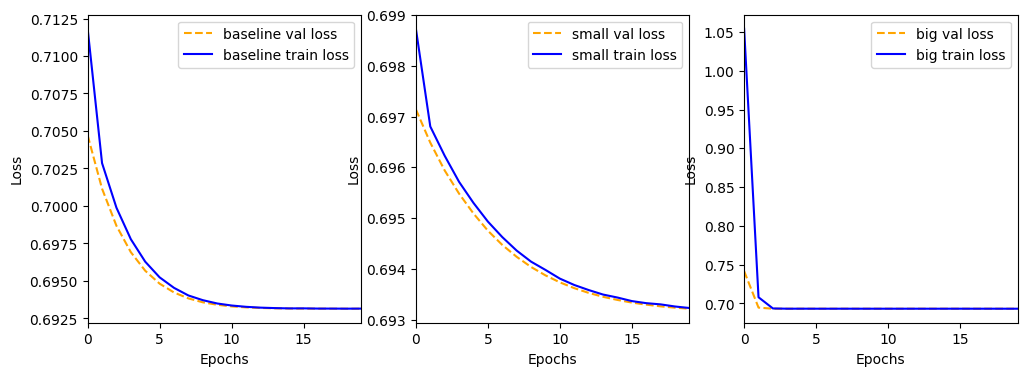

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, history) in enumerate([('baseline', history1), ('small', history2), ('big', history3)]):
    ax[i].plot(history.history['val_loss'], '--', label=name + ' val loss', color='orange')
    ax[i].plot(history.history['loss'], label=name + ' train loss', color='blue')
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].set_xlim([0, max(history.epoch)])

## Dropout 을 적용하여 같은 Test

In [21]:
regularizer = None
dropout = 0.4

model_1 = make_model(16, regularizer, dropout)
model_2 = make_model(4, regularizer, dropout)
model_3 = make_model(512, regularizer, dropout)

In [22]:
%%time
history1 = model_1.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history2 = model_2.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)
history3 = model_3.fit(X_train, train_label, epochs=20, batch_size=512, validation_data=(X_test, test_label), verbose=1)

Epoch 1/20
49/49 [==============================] - 2s 24ms/step - loss: 0.6931 - accuracy: 0.5027 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 2/20
49/49 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.4951 - binary_crossentropy: 0.6932 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 3/20
49/49 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5048 - binary_crossentropy: 0.6931 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6931
Epoch 4/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6931 - accuracy: 0.5025 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 5/20
49/49 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5002 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_bin

Epoch 1/20
49/49 [==============================] - 7s 130ms/step - loss: 0.6932 - accuracy: 0.4936 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 2/20
49/49 [==============================] - 6s 122ms/step - loss: 0.6932 - accuracy: 0.4975 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 3/20
49/49 [==============================] - 8s 155ms/step - loss: 0.6931 - accuracy: 0.4958 - binary_crossentropy: 0.6931 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 4/20
49/49 [==============================] - 8s 159ms/step - loss: 0.6932 - accuracy: 0.5016 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_binary_crossentropy: 0.6932
Epoch 5/20
49/49 [==============================] - 8s 159ms/step - loss: 0.6932 - accuracy: 0.4988 - binary_crossentropy: 0.6932 - val_loss: 0.6932 - val_accuracy: 0.5000 - va

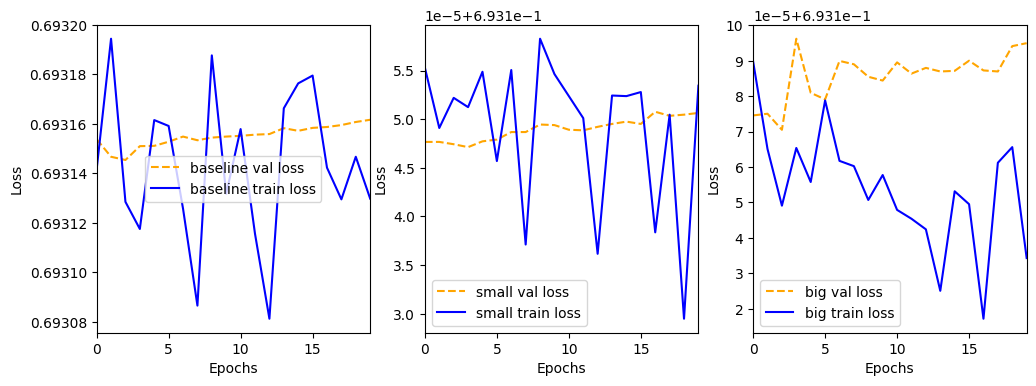

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, (name, history) in enumerate([('baseline', history1), ('small', history2), ('big', history3)]):
    ax[i].plot(history.history['val_loss'], '--', label=name + ' val loss', color='orange')
    ax[i].plot(history.history['loss'], label=name + ' train loss', color='blue')
    ax[i].legend()
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Loss')
    ax[i].set_xlim([0, max(history.epoch)])